In [31]:
import os
from glob import glob
import rasterio as rio
import numpy as np
from tqdm import tqdm,tqdm_notebook
from rasterio.plot import reshape_as_image,reshape_as_raster
import re
import pandas as pd
import json
import geopandas as gpd
from rasterio.mask import mask

import seaborn as sns
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from sklearn.cluster import MiniBatchKMeans
from rasterio.features import sieve
from rasterio.plot import reshape_as_image
from affine import Affine
from skimage.filters import threshold_multiotsu,threshold_otsu,threshold_yen,threshold_triangle,threshold_local,threshold_li

def strat_rand_sampling(file,outf,size,nodat=0,seed=None):
    #set seed for numpy random 
    np.random.seed(seed)
    
    data = []
    with rio.open(file) as src:
        
        #translate rows, cols to xy coordinates
        T0 = src.transform
        T1 = T0 * Affine.translation(0.5, 0.5)
        rc2xy = lambda r, c: T1 * (c, r) 

        img = src.read(1)
        strata = np.unique(img)[np.unique(img)!=nodat]
        
        #sample each stratum to a geopanda dataframe
        for stratum in strata: 
            
            rows,cols = np.where(img==stratum)
            idx = np.random.choice(np.arange(len(rows)), size, replace=False)
            stratified_samples = np.array([rc2xy(x, y) for x,y in zip(rows[idx],cols[idx]) ])
            x,y = stratified_samples[:,0],stratified_samples[:,1]
            gdf = gpd.GeoDataFrame(crs=str(src.crs), geometry=gpd.points_from_xy(x,y))
            gdf['class'] = stratum
            data.append(gdf)
    
    data_cat = pd.concat(data,ignore_index=True)
    data_cat.to_file(outf,driver="GeoJSON")
    print(f'Exported as: {outf}')
    
        
def compute_cluster(rws_rgb_img,k=4):
    rws_rgb_img = rws_rgb_img.astype(np.float32)/10000
    samples = reshape_as_image(rws_rgb_img).reshape(-1,rws_rgb_img.shape[0])
    kmeans_pred = MiniBatchKMeans(n_clusters=k+1, random_state=42,max_iter=10,batch_size=10000,reassignment_ratio=0).fit(samples)
    kmeans_pred_img = kmeans_pred.labels_.reshape(rws_rgb_img.shape[1], rws_rgb_img.shape[2]).astype(rio.uint16)
    return kmeans_pred_img

def compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8a','B11','B12']):
    np.seterr(divide='ignore', invalid='ignore')
    
    band_pos = get_arr(bands)
    
    raw_img = img[band_pos]

    mnws = []
    
    max_i = np.argmax(np.unique(cluster_img,return_counts=True)[1])
    all_labels = list(range(0,cluster_img.max()+1))
    labels = list(set(all_labels)-set([all_labels[max_i]]))

    for label in labels:
        
        #calculate band stats
        region_img = np.where(cluster_img==label,raw_img,0)
        band_means = np.array(list(map(lambda x:np.mean(region_img[x][region_img[x]!=0],dtype=np.float32),
                                       range(len(band_pos))))).reshape(len(band_pos),-1)
        band_std = np.array(list(map(lambda x:np.std(region_img[x][region_img[x]!=0],dtype=np.float32),
                                     range(len(band_pos))))).reshape(len(band_pos),-1)
        
        #calculate nws 
        reshaped_raw_img = raw_img.reshape(len(band_pos),-1)
        nws = (((( abs(reshaped_raw_img-band_means) /band_std)**2).sum(0)/len(band_pos))**0.5).reshape(img.shape[1],img.shape[2])
        mnws.append(nws)
        
    mnws_img = np.array(mnws).min(0)

    return mnws_img

def multitemp_clmasks(target_img,reference_img):
    np.seterr(divide='ignore', invalid='ignore')
    
    #cloud shadow = 1 and thick cloud = 2
    db8a = target_img[get_arr('b8a')]-reference_img[get_arr('b8a')]
    db11 = target_img[get_arr('b11')]-reference_img[get_arr('b11')]
    db2 = target_img[get_arr('b2')]-reference_img[get_arr('b2')]
    db3 = target_img[get_arr('b3')]-reference_img[get_arr('b3')]
    db4 = target_img[get_arr('b4')]-reference_img[get_arr('b4')]

    ndvi = compute_index(target_img,'NDVI')
    
    cl_shadow = np.where( (db8a<-400) & ( db11<-400 ),1,0)
    cl_thick = np.where( ((db2 > 800) & (db3 >800) & (db4 >800)),2,0)
    forest_sh = np.where(ndvi>0.5,3,0)
       
    cl_masks = np.array([cl_shadow,cl_thick,forest_sh])
    cl_masks = np.amax(cl_masks,axis=0)
    
    return cl_masks
        
def wcf_mnws(mnws_files,invalid_files,upland_file,thr=3,dec=2):
    
    water_rws_detected = []
    invalid_pixels = []    
    
    with rio.open(upland_file) as src_upland:
        upland_mask = src_upland.read(1)
    
        for i in tqdm(range(len(mnws_files)),position=0, leave=True):
            mnws_file = mnws_files[i]
            cl_mask_file = invalid_files[i]

            with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
                profile = src_mnws.profile.copy()
                mnws_img = src_mnws.read(1)
                mnws_img[np.isnan(mnws_img)]=9999

                cl_mask = src_mask.read(1)

                invalid = np.where(cl_mask==2,1,0)
                invalid_pixels.append(invalid)

                if thr=='otsu':
                    thr = threshold_otsu(mnws_img[(mnws_img<8)&(mnws_img>1)])

                water_rws = np.where( (mnws_img<=thr)&(upland_mask!=1),1,0)
                
                water_rws = np.where( (cl_mask==1) | (cl_mask==3),0,water_rws)
                water_rws_detected.append(water_rws)

    water_rws_detected_sum = np.array(water_rws_detected).sum(0)
    invalid_pixels_sum = np.array(invalid_pixels).sum(0)
    diff_invalid = len(mnws_files)-invalid_pixels_sum

    water_freq_img = np.true_divide(water_rws_detected_sum , diff_invalid, where=(diff_invalid!=0),dtype=np.float32)*12
    water_freq_img_r = np.round(water_freq_img,dec)
    
    return water_freq_img_r,water_rws_detected_sum,profile


def get_arr(bands):
    band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B10','B11','B12']
    if isinstance(bands,list):
        return [band_names.index(band.upper()) for band in bands]
    else:
        return band_names.index(bands.upper())
    
def compute_index(arr,name):
    np.seterr(divide='ignore', invalid='ignore')
    
    if name == 'MNDWI':
        b3= arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        index = (b3-b11)/(b3+b11)
        
    elif name == 'MNDWI2':
        b3= arr[get_arr('b3')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        index = (b3-b12)/(b3+b12)
        
    elif name == 'MNDVI':
        b5= arr[get_arr('b5')].astype(np.float32)
        b7= arr[get_arr('b7')].astype(np.float32)
        index = (b7-b5)/(b7+b5)
        
    elif name =='NDVI':
        b8a= arr[get_arr('b8a')].astype(np.float32)
        b4= arr[get_arr('b4')].astype(np.float32)
        index = (b8a-b4)/(b8a+b4)
        
    elif name =='MGRN':
        index = (arr[get_arr(['b3','b4','b8a'])].astype(np.float32)/10000).min(0)
    
    elif name =='AWEI_NSH':
        b3 = arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        b8a = arr[get_arr('b8a')].astype(np.float32)
        index = (4*(b3-b11)) -( (0.25*b8a) +(2.75*b12) )
        
    elif name =='AWEI_SH':
        b2 = arr[get_arr('b2')].astype(np.float32)
        b3 = arr[get_arr('b3')].astype(np.float32)
        b11 = arr[get_arr('b11')].astype(np.float32)
        b12 = arr[get_arr('b12')].astype(np.float32)
        b8a = arr[get_arr('b8a')].astype(np.float32)
        index = b2+2.5*b3-1.5*(b8a+b11)-0.25*b12

    return index

def compute_wiw(arr):
    b8a = arr[get_arr('b8a')].astype(np.float32)/10000
    b12 = arr[get_arr('b12')].astype(np.float32)/10000
    return np.where( ((b8a<=0.1804)) & ((b12<=0.1131)), 1, 0)

def compute_rws(arr,index_type='MNDWI',method='otsu'):
    water_index = compute_index(arr,index_type)
    mgrn = compute_index(arr,'MGRN')
    
    if method == 'otsu':
        thr = threshold_otsu(water_index[water_index>=0])
    elif method == 'li':
        thr = threshold_li(water_index[water_index>=0],initial_guess=0.3)
    
    rws = np.where( (water_index>=thr) &((mgrn>0) & (mgrn<0.15)),1,0)
    rws_img = np.where(rws==1,arr,0)
    return rws_img,rws

def wd_count(mnws_files,invalid_files,upland_file,thr=3):
    
    wd = {}
   
    with rio.open(upland_file) as src_upland:
        upland_mask = src_upland.read(1)
    
        for i in tqdm(range(len(mnws_files)),position=0, leave=True):
            mnws_file = mnws_files[i]
            date = re.findall(r"(\d{8})", mnws_file)[0]
            cl_mask_file = invalid_files[i]

            with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
                profile = src_mnws.profile.copy()
                mnws_img = src_mnws.read(1)
                mnws_img[np.isnan(mnws_img)]=9999

                cl_mask = src_mask.read(1)

                if thr=='otsu':
                    thr = threshold_otsu(mnws_img[(mnws_img<8)&(mnws_img>1)])

                water_rws = np.where( (mnws_img<=thr)&(upland_mask!=1),1,0)
                
                water_rws = np.where( (cl_mask==1) | (cl_mask==3),0,water_rws)

                wd[date] = np.count_nonzero(water_rws)
    df = pd.DataFrame(wd,index=[0]).T
    df.columns = ['pixel_count']
    return  df

def calc_acc(y_true,y_pred):
    
    observed = y_true.rename('Observed')
    classified = y_pred.rename('Classified')
    con_mat = pd.crosstab(classified,observed)
    
    row_sum = con_mat.sum(axis=1)
    col_sum = con_mat.sum(axis=0)
    omitted = np.setdiff1d(col_sum.index,row_sum.index)
    col_sum = col_sum.drop(omitted)
    
    ua = np.diag(con_mat)/row_sum
    pa = np.diag(con_mat)/col_sum
    f1 = (2 * pa*ua) /(pa+ua)
    
    oa = sum(np.diag(con_mat))/len(y_true)
    acc_df = round(pd.DataFrame({'Label':col_sum.index,'PA':pa.values,'UA':ua.values,'F1-score':f1.values}),2).fillna(0)
    
    return acc_df,con_mat

In [ ]:
%%time

#data mask computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')

nodata_list = []

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]

    with rio.open(file) as src:
        profile = src.profile.copy()

        img = src.read()
        img = np.where(img<0,0,img)
        
        nodata_img_sum = np.where(img==src.nodata,1,0).sum(0).astype(rio.uint8)
        nodata_img_mask = np.where(nodata_img_sum!=0,1,0).astype(rio.uint8)
        nodata_list.append(nodata_img_mask)
        
#inverse nodata mask        
nodata_list_sum = np.array(nodata_list).sum(0).astype(rio.uint8)
data_list_mask = np.where(nodata_list_sum!=0,0,1).astype(rio.uint8)

#sieve data to ommit isolated pixels
data_list_mask_sieved = sieve(data_list_mask,100)

outf =  f'{os.path.abspath("..")}results/data_mask.tif'

profile.update(nodata=0,count=1,dtype=data_list_mask_sieved.dtype)
with rio.open(outf,'w',**profile) as dst:
    dst.write_band(1,data_list_mask_sieved)


In [ ]:
%%time

#cloud masks computation monthly best reference image

#mosaics
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
dates = [re.findall(r"(\d{8})", file)[0] for file in mosaics]

#reference mosaics
ref_dates = [20170119,20170119,20170327,20170327,20170615,20170615,20170720,20170824,20171008,20171008,20171117,20171117]
ref_mosaics = [mos for date in ref_dates for mos in mosaics if str(date) in mos ]
months = pd.to_datetime(dates).strftime('%Y%m').unique().tolist()
ref_dict = dict(zip(months,ref_mosaics))

data_mask_file = f'{os.path.abspath("..")}results/data_mask.tif'

with rio.open(data_mask_file) as src_data_mask:
    data_mask = src_data_mask.read()

    for i in tqdm(range(len(mosaics)),position=0, leave=True):
        file = mosaics[i]
        outf = f'{ os.path.abspath("..") }results/invalid_masks_min400_ndvi03/invalid_{dates[i]}.tif'

        ref_file = [ref_dict[key] for key in list(ref_dict.keys()) if key in file][0]

        with rio.open(file) as src,rio.open(ref_file) as src_ref:
            profile = src.profile.copy()
            src_img = np.where(src.read()<0,0,src.read()).astype(rio.int16)
            src_img = np.where(data_mask==1,src_img ,src.nodata).astype(rio.int16)
            
            src_ref_img = np.where(src_ref.read()<0,0,src_ref.read()).astype(rio.int16)
            src_ref_img = np.where(data_mask==1,src_ref_img ,src.nodata).astype(rio.int16)
            
            _,rws = compute_rws(src_img,'MNDWI','otsu')
            cl_masks = multitemp_clmasks(src_img,src_ref_img).astype(rio.int8)
            cl_masks = np.where((src_img[0]!=src.nodata)&(rws!=1),cl_masks,0).astype(rio.int8)
            
            #write to new geotiff
            profile.update({'dtype':cl_masks.dtype,'nodata':0,'count':1})
            with rio.open(outf ,'w',**profile) as dst:
                dst.write_band(1, cl_masks)
                dst.set_band_description(1, f'invalid_{dates[i]}')

In [ ]:
%%time

#mnws computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')

data_mask_file = f'{os.path.abspath("..")}results/misc/data_mask.tif'

with rio.open(data_mask_file) as src_data_mask:

    data_mask = src_data_mask.read()

    for i in tqdm(range(len(mosaics)),position=0, leave=True):
        file = mosaics[i]

        outf = f'{os.path.abspath("..")}results/rws_mnws_mndwi_otsu/{os.path.basename(file)}'.replace('mosaic','rws_mnws')

        with rio.open(file) as src:
            profile = src.profile.copy()

            img = src.read()
            img = np.where(img<0,0,img)
            img = np.where(data_mask==1,img,src.nodata).astype(rio.int16)

            #compute RWS region
            rws_img,_ = compute_rws(img,'MNDWI','otsu')

            #cluster and compute MNWS
            cluster_img = compute_cluster(rws_img[get_arr(['B2','B3','B4'])],8) 
            
            mnws = compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8A','B11','B12'])
            mnws = np.where(img[0]==src.nodata,src.nodata,mnws).astype(rio.float32)

            profile.update(nodata=src.nodata,count=1,dtype=mnws.dtype)
            with rio.open(outf,'w',**profile) as dst:
                dst.write_band(1,mnws)

            


In [ ]:
def wcf_mnws(mnws_files,invalid_files,thr=3,dec=2):
    
    water_rws_detected = []
    invalid_pixels = []    
    
    for i in tqdm(range(len(mnws_files)),position=0, leave=True):
        mnws_file = mnws_files[i]
        cl_mask_file = invalid_files[i]

        with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
            profile = src_mnws.profile.copy()
            mnws_img = src_mnws.read(1)
            mnws_img[np.isnan(mnws_img)]=9999

            cl_mask = src_mask.read(1)

            invalid = np.where(cl_mask==2,1,0)
            invalid_pixels.append(invalid)

            water_rws = np.where(mnws_img<=thr,1,0)

            water_rws = np.where( cl_mask>0,0,water_rws)
            water_rws_detected.append(water_rws)

    water_rws_detected_sum = np.array(water_rws_detected).sum(0)
    invalid_pixels_sum = np.array(invalid_pixels).sum(0)
    diff_invalid = len(mnws_files)-invalid_pixels_sum

    water_freq_img = np.true_divide(water_rws_detected_sum , diff_invalid, where=(diff_invalid!=0),dtype=np.float32)*12
    water_freq_img_r = np.round(water_freq_img,dec)
    
    return water_freq_img_r,water_rws_detected_sum,profile

In [ ]:
%%time
# #compute water coverage frequency and classified map

mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/rws*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/invalid_masks_min400_ndvi05/invalid*.tif")

# water rws frequency  
wf_rws,water_sum,profile = wcf_mnws(mnws_files,cl_mask_files,thr=3,dec=2)

#reclassify to water body types
upland_file = f"{os.path.abspath('..')}results/misc/upland_gte30.tif"
data_mask_file = f'{os.path.abspath("..")}results/misc/data_mask.tif'

with rio.open(data_mask_file) as src_data_mask, rio.open(upland_file) as src_upland:
    
    #used to mask out pixels with elevation >30 m
    upland_mask = src_upland.read(1)
    
    #used to assign non-water pixels (class value = 0)
    data_mask = src_data_mask.read(1)
    
    #reclassification of WF image
    dwm = wf_rws.copy()
    wetland = ((dwm >0)&(dwm <3))*2     #wetland
    sw = ((dwm >=3)&(dwm <=9))*3        #seasonal water
    pw = (dwm>9)*4                      #permanent water
    
    dwm_sum = np.where(upland_mask==1,0,np.array([wetland,sw,pw]).sum(0))
    dwm_out = np.where(dwm_sum>0,dwm_sum,data_mask).astype(rio.uint8)

    #sieve data
    dwm_out_sieved = sieve(dwm_out,size=30,connectivity=8)
    
#     #export rasters
#     out_wf = f"{os.path.abspath('..')}results/wf_rws.tif"
#     profile.update({'dtype':wf_rws.dtype,'nodata':0,'count':1})
#     with rio.open(out_wf,'w',**profile) as dst: dst.write_band(1,wf_rws)

#     out_water_sum = f"{os.path.abspath('..')}results/watersum.tif"
#     profile.update({'dtype':rio.uint8,'nodata':0,'count':1})
#     with rio.open(out_water_sum,'w',**profile) as dst: dst.write_band(1,water_sum.astype(rio.uint8))

    out_dwm = f"{os.path.abspath('..')}results/dwm_ndvi05_sieved_invalid.tif"
    profile.update({'dtype':rio.uint8,'nodata':0,'count':1})
    with rio.open(out_dwm ,'w',**profile) as dst: dst.write_band(1,dwm_out_sieved)


In [ ]:
conf_rate = pd.read_csv(glob(f"./data/sample/accuracy_assesment/*.csv")[0])

classified_points = gpd.read_file(glob(f"./data/sample/accuracy_assesment/*.shp")[0])
coords = list((zip(classified_points['geometry'].centroid.x,classified_points['geometry'].centroid.y)))

dwm_file =  f"{os.path.abspath('..')}results/dwm_ndvi05_sieved_invalid.tif"
jrc_file= f"{os.path.abspath('..')}ancillary_data/YearlyHistory_2017_masked.tif"

with rio.open(dwm_file) as src, rio.open(jrc_file) as src_jrc:
    classified_points['Classified'] = [val[0] for val in src.sample(coords)]
    
    jrc_reclassified = []
    for val in src_jrc.sample(coords):
        if val[0] == 3:
            jrc_reclassified.append(4)
        elif val[0] == 2:
            jrc_reclassified.append(3)
        elif val[0] == 1:
            jrc_reclassified.append(2)
        elif val[0] == 0:
            jrc_reclassified.append(1)
        else:
            jrc_reclassified.append(val[0])
    classified_points['jrc_classified'] = jrc_reclassified
    
classified_points.loc[:,['jrc_classified']] = classified_points.loc[:,['jrc_classified']].replace(0,1)
classified_points['match'] = (classified_points['Classif ID'] == classified_points['Classified'])*1
classified_points.loc[:,'match']=classified_points.loc[:,'match'].replace(1,'Yes')
classified_points.loc[:,'match']=classified_points.loc[:,'match'].replace(0,'No')

classified_points['label_confidence'] = conf_rate['rating'].str[0].str.upper()+conf_rate['rating'].str[1]

#convert/ merge wl(=2) with sw(=3)
# classified_points.loc[:,['jrc_classified','Classified','Classif ID']] = classified_points.loc[:,['jrc_classified','Classified','Classif ID']].replace(2,3)

#export data
# outf =  f"./data/sample/accuracy_assesment/classified_rated.geojson"
# classified_points.to_file(outf,driver="GeoJSON")

#compute accuracy table
acc_df,con_mat = calc_acc(classified_points['Classif ID'],classified_points['Classified'])
acc_df_merged = pd.concat([con_mat,acc_df.set_index('Label')],1)
oa = round(np.diag(acc_df_merged)[[0,2,-1]].sum()/(52*3),2)
print('Sentinel-2 DWM\n\n',acc_df_merged,oa)

acc_df,con_mat = calc_acc(classified_points['Classif ID'],classified_points['jrc_classified'])
acc_df_merged = pd.concat([con_mat,acc_df.set_index('Label')],1)
oa = round(np.diag(acc_df_merged)[[0,2,-1]].sum()/(52*3),2)
print('JRC-GSWS\n\n',acc_df_merged,oa)

In [ ]:
%%time
# count water area
mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/rws*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/invalid_masks_min400_ndvi05/invalid*.tif")
upland_file = f"{os.path.abspath('..')}results/misc/upland_gte30.tif"
wd_df = wd_count(mnws_files,cl_mask_files,upland_file,thr=3)



In [ ]:
wd_df.index = pd.to_datetime(wd_df.index)
plt.figure(figsize=(10,5))
plt.plot(wd_df*0.0001);

In [ ]:
dwm_file = f"{os.path.abspath('..')}results/dwm_ndvi05.tif"
mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/rws*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/invalid_masks_min400_ndvi05/invalid*.tif")
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
dates = [re.findall(r"(\d{8})", file)[0] for file in mosaics]

wetland_file = f"{os.path.abspath('..')}results/wetland_aoi.tif"

with rio.open(dwm_file) as src_dwm, rio.open(wetland_file) as src_wetland:

    dwm = src_dwm.read(1)
    wetland_aoi = src_wetland.read(1)
    dwm = np.where(wetland_aoi==1,dwm,0)
    
    data = []
    
    for i in tqdm(range(len(mosaics)),position=0, leave=True):

        with rio.open(mosaics[i]) as src, rio.open(mnws_files[i]) as src_mnws,rio.open(cl_mask_files[i]) as src_clm:

            img = src.read()
            clm = src_clm.read()
            img = np.where(img<0,0,img)
            ndvi = compute_index(img,'NDVI')
            mndwi = compute_index(img,'MNDWI')
            mnws = src_mnws.read(1)
            
            wi_arr = np.array([ndvi,mndwi,mnws])
            wi_arr = np.where(clm==3,9999,wi_arr)
            
            values = []
            for i in range(1,4):
                val_arr = np.where(wi_arr[:,dwm==i]!=9999,wi_arr[:,dwm==i],np.nan)
                values += np.nanmean(val_arr,1).tolist()
            data.append(values)
    df = pd.DataFrame(np.array(data))
    df.columns = ['NDVI_WL','MNDWI_WL','MNWS_WL','NDVI_SW','MNDWI_SW','MNWS_SW','NDVI_PW','MNDWI_PW','MNWS_PW']
    df = df.set_index(pd.to_datetime(dates))
    df.to_csv('./data/dwm_median_values.csv')

In [ ]:
df = pd.read_csv('./data/dwm_median_values.csv',index_col=[0])
df.index = pd.to_datetime(df.index)

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(df.iloc[:,:2])
axs[1].plot(df.iloc[:,2:3],color='red')
axs[1].axhline(3, 8,0,ls='--',color='black',lw=2)
axs[0].legend(df.iloc[:,:2].columns)
axs[1].legend(df.iloc[:,2:3].columns);

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(df.iloc[:,3:5])
axs[1].plot(df.iloc[:,5:6],color='red')
axs[1].axhline(3, 8,0,ls='--',color='black',lw=2)
axs[0].legend(df.iloc[:,3:5].columns)
axs[1].legend(df.iloc[:,5:6].columns);

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(df.iloc[:,6:8])
axs[1].plot(df.iloc[:,8:],color='red')
axs[1].axhline(3, 8,0,ls='--',color='black',lw=2)
axs[0].legend(df.iloc[:,6:8].columns)
axs[1].legend(df.iloc[:,8:]);


In [ ]:
def strat_rand_sampling(file,size,vstride_nr,nodat=0,seed=None):
    #set seed for numpy random 
    np.random.seed(seed)
    
    data = []
    with rio.open(file) as src:
        
        #translate rows, cols to xy coordinates
        T0 = src.transform
        T1 = T0 * Affine.translation(0.5, 0.5)
        rc2xy = lambda r, c: T1 * (c, r) 

        img = src.read(1)
        profile = src.profile.copy()
        block_img = img.copy()
        
        vstride = int(block_img.shape[0]/vstride_nr)
        
        for i in range(0,block_img.shape[0],vstride):
            random_label = int((i+vstride)/100)
            if i+vstride<block_img.shape[0]:
                block_img[i:i+vstride,:][block_img[i:i+vstride,:]>=0] = random_label
            else:
                block_img[i:,:][block_img[i:,:]>=0] = random_label
            
        stack_img = np.where(img>0,block_img,nodat).astype(rio.uint16)
        
        strata = np.unique(stack_img)[np.unique(stack_img)!=nodat]
        classes = np.unique(img)[np.unique(img)!=nodat]
        
        for grid in strata: 
            for c in classes:
                rows,cols = np.where((img==c)&(stack_img==grid))
        
                if len(rows)!=0:
                    idx = np.random.choice(range(len(cols)), size, replace=False)
                    stratified_samples = np.array([rc2xy(x, y) for x,y in zip(rows[idx],cols[idx]) ])
                    x,y = stratified_samples[:,0],stratified_samples[:,1]
                    gdf = gpd.GeoDataFrame(crs=str(src.crs), geometry=gpd.points_from_xy(x,y))
                    gdf['class'] = c
                    data.append(gdf)
        
        profile.update(nodata=0,dtype=stack_img.dtype)
        data_cat = pd.concat(data,ignore_index=True)
        return data_cat,stack_img.astype(rio.uint8),profile



In [ ]:
#create stratified random samples
file = glob(f'{os.path.abspath("..")}results/dwm*.tif')[0]

seed = 42

gdf,block_img,block_profile = strat_rand_sampling(file=file,size=13,vstride_nr = 4,nodat=0,seed=seed)


print(gdf.groupby('class').count())

#drop class with sample points larger than 50
# indices2drop = gdf[gdf['class']==1].sample(n=5,random_state = seed).index
# gdf = gdf.drop(indices2drop).reset_index(drop=True)

#add class description
gdf['desc'] = None
for c_code,c_desc in zip(gdf['class'].unique(),['Nw','Wl','Sw','Pw']):
    gdf.loc[gdf[gdf['class']==c_code].index,'desc'] = c_desc
    
print(gdf.groupby('class').count())

#xport sample points
gdf_file = './data//sample/stratified_random_52samples_segmented.geojson'
gdf.to_file(gdf_file,driver="GeoJSON")

#xport image block
with rio.open('./data//sample/blocks.tif','w',**profile) as dst:
    dst.write_band(1,block_img)

In [91]:
def mnws_boxplot(data):
    labels = data.columns
    
    plt.figure(figsize=(10,5))
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
    sns.boxplot(data=data,order=labels,flierprops=flierprops,whis=[5, 95],orient='h',palette='husl',linewidth=1)
    plt.xlabel('MNWS',fontsize=16)
    plt.ylabel('Land cover',fontsize=16)
    plt.title('MNWS land cover types 25 Feb 2017 ',fontsize=20)
    plt.xticks(range(0, int(data.max().max()), 5))
    plt.axvline(3, 8,0,ls='--',color='black',lw=2)
    plt.show()

def plot_bands(band_data_mean,band_data_std):
    fsize = 16
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    plt.figure(figsize=(15,10))
    colors=['blue','orange','brown','yellow','green','purple','red','black']
    axs = [sns.lineplot(data=band_data.loc[band_data_mean.index[i]]/10000,sort=False,color=colors[i]) for i in range(len(band_data_mean.index))]
    axs[0].lines[0].set_linestyle("--")
    plt.legend(band_data_mean.index,loc='upper left',fontsize=fsize)
    plt.ylabel('Surface Reflectance',fontsize=fsize)
    
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.fill_between(band_data.columns.tolist(),(band_data_mean.iloc[0]/10000)-(band_data_std.iloc[0]/10000), (band_data_mean.iloc[0]/10000)+(band_data_std.iloc[0]/10000), alpha=.3)
    plt.fill_between(band_data.columns.tolist(),(band_data_mean.iloc[-1]/10000)-(band_data_std.iloc[-1]/10000), (band_data_mean.iloc[-1]/10000)+(band_data_std.iloc[-1]/10000), alpha=.3,color=colors[-1])

    plt.show()

In [229]:
%%time

hdd_mount = "D:\minor_thesis\images"

# MNWS and band stats example 25 Feb 2017
gdf = gpd.read_file(glob(f'./mapping-wetlands/data/sample/*_20170225.geojson')[0])

long_names = ['Water','Settlement','Dark soil',' Bright soil','Vegetation','Agriculture','Cloud','Cloud shadow']

labels = dict(zip(gdf ['code'].unique(),long_names))
geom_code = list((zip(gdf ['geometry'].tolist(), gdf ['code'].tolist() )))

mosaic = glob(f'./images/*_20170225.tif')[0]
mnws = glob(f'./results/rws_mnws_mndwi_otsu/*_20170225.tif')[0]

bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
nm = ['490','560','665','705','750','783','842','865','1910','2190']
band_names = [f'{a}\n{b} nm' for a,b in zip(bands,nm)]

with rio.open(mosaic) as src,rio.open(mnws) as src_mnws:
    
    img = src.read()
    img = img[get_arr(bands)]
    img_mnws = src_mnws.read()
    
    sample_mask = rasterize(shapes=geom_code, out_shape=src.shape, transform=src.transform)
    
    #band stats
    band_data = pd.concat([pd.DataFrame(np.median(img[:,sample_mask==code],1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data.columns = band_names
    band_data_std = pd.concat([pd.DataFrame(img[:,sample_mask==code].std(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data_std.columns = band_names
    
    #mnws stats
    mnws_data = pd.concat([pd.DataFrame(img_mnws[:,sample_mask==code]).T for code in list(labels.keys())],axis=1)
    mnws_data.columns = list(labels.values())



Wall time: 17 s


In [114]:
%%time
band_combo = [ ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'],
               ['B2','B3','B4','B5','B11','B12'],
               ['B2','B3','B4','B6','B11','B12'],
               ['B2','B3','B4','B7','B11','B12'],
               ['B2','B3','B4','B8','B11','B12'],
               ['B2','B3','B4','B8A','B11','B12'],
               ['B2','B3','B4','B11','B12']  ]

data_combo = []

with rio.open(mosaic) as src:
    img = np.where(src.read()<0,0,src.read())
    
    #compute RWS region
    rws_img,_ = compute_rws(img,'MNDWI','otsu')

    #cluster and compute MNWS
    cluster_img = compute_cluster(rws_img[get_arr(['B2','B3','B4'])],8) 
    sample_mask = rasterize(shapes=geom_code, out_shape=src.shape, transform=src.transform)
    
    for i in tqdm(range(len(band_combo)),position=0, leave=True):
    
        img_mnws = compute_mnws(img,cluster_img,bands=band_combo[i])

        mnws_data = pd.concat([pd.DataFrame(img_mnws[sample_mask==code]) for code in list(labels.keys())],axis=1)
        mnws_data.columns = list(labels.values())
        mnws_data = mnws_data.iloc[:,[0,1,2,4,5,7]]
        data_combo.append(mnws_data)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:13<00:00, 51.55s/it]


Wall time: 6min 55s


In [196]:
    val = '%.2f'%distance
    axs[i].text(0.5, 1, f'Median distance:{val}',fontsize=fsize, ha='center', va='center', rotation='horizontal')


0.6522490978240967

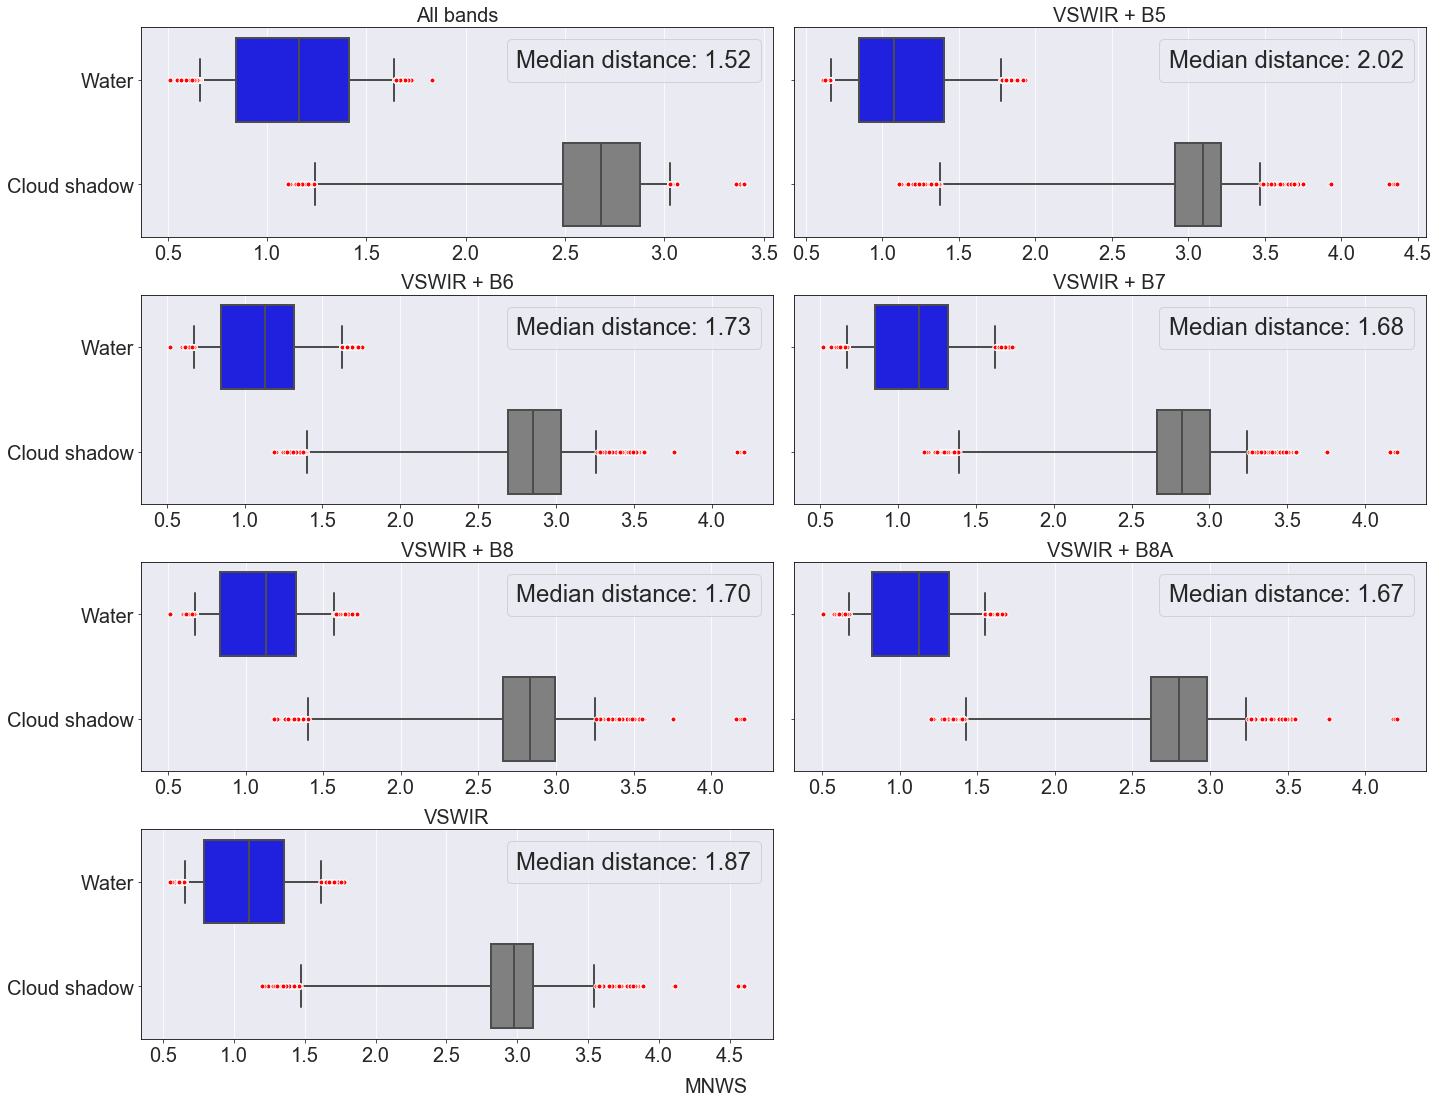

In [231]:
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})


fig, axs = plt.subplots(4,2,figsize=(20,15),sharey=True)
axs = axs.ravel()
fsize = 20
flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')

titles= ['All bands','VSWIR + B5','VSWIR + B6','VSWIR + B7','VSWIR + B8','VSWIR + B8A','VSWIR']

colors=['blue','grey']

for i in range(len(data_combo)):
    
    data2plot = data_combo[i][['Water','Cloud shadow']]
    sns.boxplot(data=data2plot,order=data2plot.columns,
                flierprops=flierprops,whis=[5, 95],orient='h'
                ,linewidth=2,ax=axs[i],palette=colors)
    axs[i].tick_params(axis='both', labelsize=fsize)
    
    axs[i].set_title(titles[i],fontsize=20)
    axs[-1].axis('off')
    
    
    stats = data2plot.describe().loc[['mean','min','max']].T
    stats['median'] = data2plot.median()
    distance = stats.loc['Cloud shadow','median'] -stats.loc['Water','median']
    val = '%.2f'%distance
    axs[i].legend([f'Median distance: {val}'],fontsize=fsize+4,handlelength=0, handletextpad=0, fancybox=True)

fig.text(0.5, -0.01, 'MNWS',fontsize=fsize, ha='center', va='center', rotation='horizontal')

plt.tight_layout();

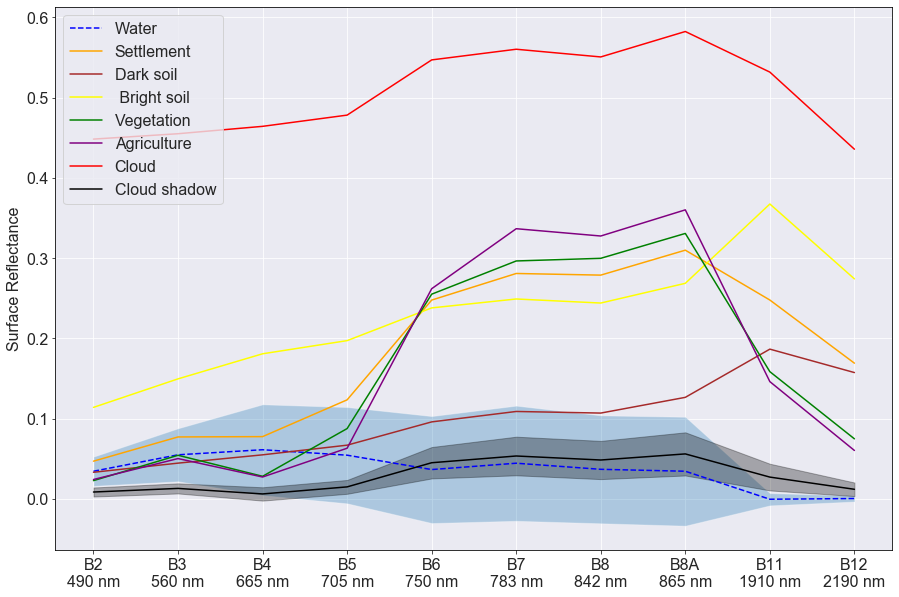

In [230]:
plot_bands(band_data,band_data_std)


In [ ]:
#compute  MNWS time-series
mosaics= glob(f"{os.path.abspath('..')}results/rws_mnws_mndwi_otsu/*.tif")
ts_sample = glob('./data/sample/ts_sample*.geojson')[0]
geo_ts_sample = gpd.read_file(ts_sample)
coords = list((zip(geo_ts_sample['geometry'].centroid.x,geo_ts_sample['geometry'].centroid.y)))

dates=[]

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    date = re.findall(r"(\d{8})", file)[0]
    
    if date !='20171120':
        dates.append(date)
        col_name = str(pd.to_datetime(date).date())

        with rio.open(file) as src:
            #sample mnws time-series
            geo_ts_sample[col_name] = [val[0] for val in src.sample(coords)]
            
geo_ts_sample.iloc[:,4:] = geo_ts_sample.iloc[:,4:].round(3)

plt.figure(figsize=(15,8))
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
ax = sns.lineplot(data=geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:],palette=['red','blue','orange'])
[ax.lines[i].set_linestyle("-") for i in range(3)]
plt.legend(geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:].columns[0:],loc='upper right',fontsize=16)
ax.set_xticklabels(pd.to_datetime(pd.Series(dates)).dt.strftime('%d-%b'))
plt.axhline(3, 8,0,ls='--',color='black',lw=2)
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Value',fontsize=16)
plt.title('MNWS time-series 2017',fontsize=20)

#rain data
rain_df = pd.read_csv('./data/rain_data.csv',index_col=[0])
rain_df['mm'] = rain_df['mm'].astype(float)

plt.figure(figsize=(15,8))
sns.lineplot(data=rain_df,x='Date',y='mm')
plt.xticks(np.arange(0, len(rain_df),31),labels=pd.to_datetime(rain_df['Date']).dt.strftime('%b')[::31] )

plt.xlabel('Month',fontsize=16)
plt.ylabel('Precipitation (mm)',fontsize=16)


plt.show()

In [ ]:
#open sun and atmospheric data
sun_data_df = pd.read_csv('./data/sun_data.csv', index_col=0)
sun_data_df['Date'] = pd.to_datetime(sun_data_df['Date'])

sun_data_df['Date_format'] = sun_data_df['Date'].dt.strftime('%d-%b')
sun_data_df = sun_data_df.set_index('Date_format')
sun_data_df['Months'] = pd.to_datetime(sun_data_df['Date']).dt.strftime('%b')
sun_data_df.columns

In [ ]:
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
fig, axs = plt.subplots(3,1,figsize=(15,10),sharex=True)

angles = sun_data_df.columns[1:5]

fsize = 16
col = ['red','green','blue','orange']
for i in range(len(angles)):
    if 'SOLAR' in angles[i]:
        axs[0].plot(sun_data_df[angles[i]],color=col[i])
        axs[0].margins(x=0)
        axs[0].legend(labels= angles[0:2],fontsize=fsize)
        axs[0].tick_params(axis='both', labelsize=fsize )
    else:
        axs[i-1].plot(sun_data_df[angles[i]],color=col[i])
        axs[i-1].tick_params(axis='both', labelsize=fsize )
        axs[i-1].tick_params(axis="x", labelrotation=45)
        axs[i-1].legend(labels= [angles[i]],fontsize=fsize,handlelength=0, handletextpad=0)
fig.text(0, 0.5, 'Degree (°)',fontsize=fsize , ha='center', va='center', rotation='vertical')
plt.tight_layout();

In [ ]:
labels = [l for l in sun_data_df.columns if 'IRRADIANCE' in l]

fig, axs = plt.subplots(5,2,figsize=(20,10),sharex=True)
axs = axs.ravel()
fsize = 20
for i in range(len(labels)):
    axs[i].plot(sun_data_df[labels [i]].astype(int))
    axs[i].tick_params(axis='both', labelsize=fsize)
    axs[i].tick_params(axis="x", labelrotation=45)
    axs[i].legend(labels= [labels[i].split('_')[-1]],loc='upper left',fontsize=fsize,handlelength=0, handletextpad=0)
    axs[i].margins(x=0)

fig.text(0, 0.5, 'Solar irradiance (W/m2)',fontsize=fsize, ha='center', va='center', rotation='vertical')
plt.xticks(np.arange(0, len(sun_data_df),8),labels=sun_data_df['Months'][::8],fontsize=fsize)
plt.tight_layout();

In [118]:
labels = sun_data_df.columns[-4:-1]

fig, axs = plt.subplots(1,3,figsize=(25,5),sharex=True)
axs = axs.ravel()
fsize = 20
units = [' (g/cm2)',' (DU)',' (unitless)']
for i in range(len(labels)):
    axs[i].plot(sun_data_df[labels [i]])
    axs[i].tick_params(axis='both', labelsize=fsize)
    axs[i].tick_params(axis="x", labelrotation=45)
    axs[i].legend(labels= [labels[i].upper()+ units[i] ],loc='upper left',fontsize=fsize,handlelength=0, handletextpad=0)
    axs[i].margins(x=0)
 
plt.xticks(np.arange(0, len(sun_data_df),8),labels=sun_data_df['Months'][::8],fontsize=fsize)
plt.tight_layout();

NameError: name 'sun_data_df' is not defined

In [ ]:
import datetime
import pandas as pd
import math
sun_data_df = pd.read_csv('./data/sun_data.csv', index_col=0)
sun_data_df['Date'] = pd.to_datetime(sun_data_df['Date'])

d_df = {'doy':[],'date':[],'distance':[]}

for date in sun_data_df['Date']:
    
    doy = date.timetuple().tm_yday
    d = 1 - 0.01672 * math.cos(0.9856 * (doy-4))
    d_df['doy'].append(doy)
    d_df['date'].append(date.date())
    d_df['distance'].append(round(d,3))
d_df  = pd.DataFrame(d_df)
d_df['date'] = pd.to_datetime(d_df['date']).dt.strftime('%d-%b')

In [ ]:
fsize = 14
xticks = [' '.join(x) for x in zip(d_df['date'].astype(str),'(' +d_df['doy'].astype(str)+ ')')]
plt.figure(figsize=(15,8))
plt.plot(d_df['distance'])
plt.xticks(np.arange(0, len(xticks)),labels=xticks,rotation=45,fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.ylabel('Earth-Sun distance (AU)',fontsize=fsize)
plt.margins(x=0);